In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch.nn as nn
import torch
import itertools

from emnist import get_emnist_data_loaders
from models.crnn.crnn import CRNN
from models.lstm_cnn.lstm_cnn import CNN_LSTM
from training.trainer import Trainer
from hyperparameter import common_hyperparameters, model_specific_hyperparameters
from evaluation.loss import plot_loss, plot_multiple_losses
from evaluation.evaluations_utils import create_directory_if_not_exists
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ExponentialLR, CosineAnnealingLR, LambdaLR, CyclicLR

/Users/simon/opt/anaconda3/envs/s2s_learning_seminar/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Generate all possible combinations of hyperparameters
param_combinations = list(itertools.product(*model_specific_hyperparameters.values()))
print(f"Number of Hyperparameter combinations: {len(param_combinations)}")

# TODO Remove in final notebook
param_combinations = param_combinations[:3]

Number of Hyperparameter combinations: 12


In [4]:
trainers = {}
for param_combination in param_combinations: 
    
    gru_hidden_size = param_combination[0]
    gru_num_layers = param_combination[1]
    cnn_output_height = param_combination[2]
    cnn_output_width = param_combination[3]
    learning_rate = param_combination[4]
    batch_size = param_combination[5]
    batch_size_val = param_combination[6]

    print(f"Testing parameters: \n"
          f"GRU Hidden Size: {gru_hidden_size}, \n"
          f"GRU Num Layers: {gru_num_layers}, \n"
          f"CNN Output Height: {cnn_output_height}, \n"
          f"CNN Output Width: {cnn_output_width}, \n"
          f"Learning Rate: {learning_rate}, \n"
          f"Batch Size: {batch_size}, \n"
          f"Validation Batch Size: {batch_size_val} \n")

    num_classes = common_hyperparameters["NUM_CLASSES"]   
    blank_label = common_hyperparameters["BLANK_LABEL"]
    image_height = common_hyperparameters["IMAGE_HEIGHT"]
    digits_per_sequence = common_hyperparameters["DIGITS_PER_SEQUENCE"]
    number_of_sequences = common_hyperparameters["NUMBER_OF_SEQUENCES"]
    epochs = common_hyperparameters["EPOCHS"]
    weight_decay = common_hyperparameters["WEIGHT_DECAY"]

    # Load data
    train_loader, val_loader, test_loader = get_emnist_data_loaders(number_of_sequences, digits_per_sequence, batch_size, batch_size_val)


    # Setup model
    models = {
        # "lstm_cnn": CNN_LSTM(gru_hidden_size=gru_hidden_size, gru_num_layers=gru_num_layers, num_classes=num_classes, cnn_output_height=cnn_output_height),
        "crnn": CRNN(gru_hidden_size, gru_num_layers, num_classes, cnn_output_height)
    }

    criteria = {
        "crnn": nn.CTCLoss(blank=common_hyperparameters['BLANK_LABEL'], reduction='mean', zero_infinity=True),
        "lstm_cnn": nn.CTCLoss(blank=common_hyperparameters['BLANK_LABEL'], reduction='mean', zero_infinity=True)
    }

    optimizer_configs = {
        "adam": torch.optim.Adam,
        # "adam_w": torch.optim.AdamW,
        # "adam_w_regulise": torch.optim.AdamW
    }

    scheduler_configs = {
        "step_lr": (StepLR, {"step_size": 5, "gamma": 0.5}),
        "no_scheduler": (None, None),
        # "multi_step_lr": (MultiStepLR, {"milestones": [5, 10, 15], "gamma": 0.5}),
        # "exponential_lr": (ExponentialLR, {"gamma": 0.95}),
        # "cosine_annealing_lr": (CosineAnnealingLR, {"T_max": 10}),
        # "lambda_lr": (LambdaLR, {"lr_lambda": lambda epoch: 0.95 ** epoch}),
        # "cyclic_lr": (CyclicLR, {"base_lr": 0.001, "max_lr": 0.1})
    }

    # Setup trainer
    # lstm_trainer =  Trainer(models["lstm_cnn"], criterions["lstm_cnn"], optimizers["lstm_cnn"], train_loader, val_loader, test_loader, epochs=epochs, args={
    #         "blank_label": blank_label,
    #         "cnn_output_width": cnn_output_width,
    #     })
    # trainers = {
    #     "lstm_cnn": lstm_trainer
    # }

    for model_name, model in models.items():
        for optimizer_name, optimizer_class in optimizer_configs.items():
            if optimizer_name == "adam_w_regulise":
                optimizer = optimizer_class(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            else:
                optimizer = optimizer_class(model.parameters(), lr=learning_rate)
            for scheduler_name, (scheduler_class, scheduler_args) in scheduler_configs.items():
                if scheduler_name == "no_scheduler":
                    scheduler = None
                else:
                    scheduler = scheduler_class(optimizer, **scheduler_args)
                criterion = criteria[model_name]

                # Create model name
                abbreviation = f"G{gru_hidden_size}__L{gru_num_layers}__H{cnn_output_height}__W{cnn_output_width}__LR{learning_rate}__BS{batch_size}__BSV{batch_size_val}"
                abbreviation = abbreviation.replace(".", "_")
                main_model_name = model_name.split('-', 1)[0]
                trainer_name = f"{model_name}-{optimizer_name}_{scheduler_name}_{abbreviation}"

                trainer = Trainer(
                    model, model_name, criterion, optimizer, train_loader, val_loader, test_loader,
                    epochs=epochs, args={"blank_label": blank_label, "cnn_output_width": cnn_output_width},
                    scheduler=scheduler
                )
                # trainer.to_device("mps")
                trainers[trainer_name] = trainer
print(f"Prepared {len(trainers)} models for training.")

Testing parameters: 
GRU Hidden Size: 128, 
GRU Num Layers: 2, 
CNN Output Height: 4, 
CNN Output Width: 32, 
Learning Rate: 0.01, 
Batch Size: 64, 
Validation Batch Size: 64 

Testing parameters: 
GRU Hidden Size: 128, 
GRU Num Layers: 2, 
CNN Output Height: 4, 
CNN Output Width: 32, 
Learning Rate: 0.01, 
Batch Size: 128, 
Validation Batch Size: 64 

Testing parameters: 
GRU Hidden Size: 128, 
GRU Num Layers: 2, 
CNN Output Height: 4, 
CNN Output Width: 32, 
Learning Rate: 0.001, 
Batch Size: 64, 
Validation Batch Size: 64 

Prepared 6 models for training.


In [5]:
for key in trainers.keys():  
    print(key)

crnn-adam_step_lr_G128__L2__H4__W32__LR0_01__BS64__BSV64
crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_01__BS64__BSV64
crnn-adam_step_lr_G128__L2__H4__W32__LR0_01__BS128__BSV64
crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_01__BS128__BSV64
crnn-adam_step_lr_G128__L2__H4__W32__LR0_001__BS64__BSV64
crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_001__BS64__BSV64


Training crnn-adam_step_lr_G128__L2__H4__W32__LR0_01__BS64__BSV64
100%|██████████| 11/11 [00:03<00:00,  3.43it/s]
EPOCH 1/8 - TRAINING. Loss: 5.693244457244873 - Correct: 0/700 = 0.0000 - Average CER Score: 0.921
100%|██████████| 5/5 [00:00<00:00, 11.37it/s]
EPOCH 1/8 - VALIDATING. Loss: 2.9579503536224365 -  Correct: 0/299 = 0.0000 - Average CER Score: 1.0
100%|██████████| 11/11 [00:03<00:00,  3.32it/s]
EPOCH 2/8 - TRAINING. Loss: 2.9302239418029785 - Correct: 0/700 = 0.0000 - Average CER Score: 0.96
100%|██████████| 5/5 [00:00<00:00, 10.85it/s]
EPOCH 2/8 - VALIDATING. Loss: 2.7525081634521484 -  Correct: 0/299 = 0.0000 - Average CER Score: 1.0
100%|██████████| 11/11 [00:02<00:00,  3.68it/s]
EPOCH 3/8 - TRAINING. Loss: 2.685504198074341 - Correct: 0/700 = 0.0000 - Average CER Score: 0.974
100%|██████████| 5/5 [00:00<00:00, 11.20it/s]
EPOCH 3/8 - VALIDATING. Loss: 2.642543077468872 -  Correct: 0/299 = 0.0000 - Average CER Score: 1.0
100%|██████████| 11/11 [00:03<00:00,  3.39it/s]
EPOCH

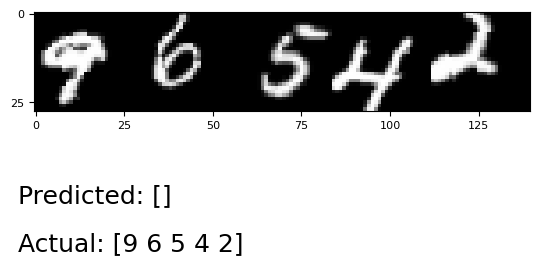

Finished training crnn-adam_step_lr_G128__L2__H4__W32__LR0_01__BS64__BSV64 and took 29.48874306678772 seconds.
Training crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_01__BS64__BSV64
100%|██████████| 11/11 [00:02<00:00,  3.86it/s]
EPOCH 1/8 - TRAINING. Loss: 2.527005195617676 - Correct: 0/700 = 0.0000 - Average CER Score: 1.0
100%|██████████| 5/5 [00:00<00:00, 10.66it/s]
EPOCH 1/8 - VALIDATING. Loss: 2.484241485595703 -  Correct: 0/299 = 0.0000 - Average CER Score: 1.0
100%|██████████| 11/11 [00:02<00:00,  3.85it/s]
EPOCH 2/8 - TRAINING. Loss: 2.4915857315063477 - Correct: 0/700 = 0.0000 - Average CER Score: 1.0
100%|██████████| 5/5 [00:00<00:00, 11.34it/s]
EPOCH 2/8 - VALIDATING. Loss: 2.4629688262939453 -  Correct: 0/299 = 0.0000 - Average CER Score: 1.0
100%|██████████| 11/11 [00:02<00:00,  3.91it/s]
EPOCH 3/8 - TRAINING. Loss: 2.428510904312134 - Correct: 0/700 = 0.0000 - Average CER Score: 1.0
100%|██████████| 5/5 [00:00<00:00, 11.72it/s]
EPOCH 3/8 - VALIDATING. Loss: 2.42491888999

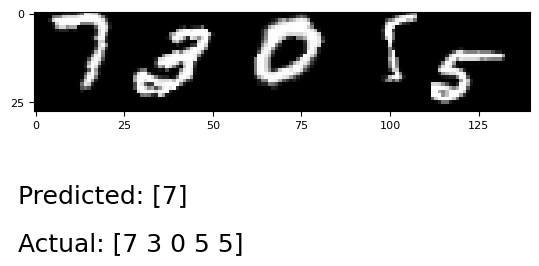

Finished training crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_01__BS64__BSV64 and took 27.876799821853638 seconds.
Training crnn-adam_step_lr_G128__L2__H4__W32__LR0_01__BS128__BSV64
100%|██████████| 6/6 [00:02<00:00,  2.08it/s]
EPOCH 1/8 - TRAINING. Loss: 10.580273628234863 - Correct: 0/700 = 0.0000 - Average CER Score: 0.927
100%|██████████| 5/5 [00:00<00:00,  9.92it/s]
EPOCH 1/8 - VALIDATING. Loss: 10.817517280578613 -  Correct: 0/299 = 0.0000 - Average CER Score: 0.9
100%|██████████| 6/6 [00:02<00:00,  2.07it/s]
EPOCH 2/8 - TRAINING. Loss: 3.2290635108947754 - Correct: 0/700 = 0.0000 - Average CER Score: 0.925
100%|██████████| 5/5 [00:00<00:00, 10.99it/s]
EPOCH 2/8 - VALIDATING. Loss: 3.077700614929199 -  Correct: 0/299 = 0.0000 - Average CER Score: 0.95
100%|██████████| 6/6 [00:02<00:00,  2.14it/s]
EPOCH 3/8 - TRAINING. Loss: 3.2907767295837402 - Correct: 0/700 = 0.0000 - Average CER Score: 0.95
100%|██████████| 5/5 [00:00<00:00, 11.26it/s]
EPOCH 3/8 - VALIDATING. Loss: 3.2422482

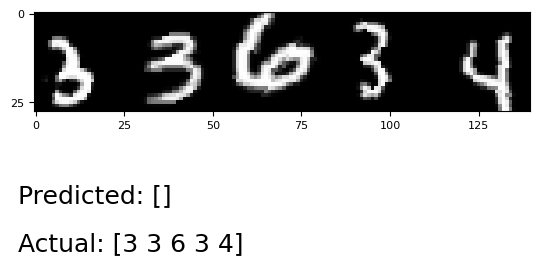

Finished training crnn-adam_step_lr_G128__L2__H4__W32__LR0_01__BS128__BSV64 and took 28.914066076278687 seconds.
Training crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_01__BS128__BSV64
100%|██████████| 6/6 [00:03<00:00,  1.77it/s]
EPOCH 1/8 - TRAINING. Loss: 2.633186101913452 - Correct: 0/700 = 0.0000 - Average CER Score: 1.0
100%|██████████| 5/5 [00:00<00:00, 10.77it/s]
EPOCH 1/8 - VALIDATING. Loss: 2.6369264125823975 -  Correct: 0/299 = 0.0000 - Average CER Score: 1.0
100%|██████████| 6/6 [00:03<00:00,  1.85it/s]
EPOCH 2/8 - TRAINING. Loss: 2.6349897384643555 - Correct: 0/700 = 0.0000 - Average CER Score: 1.0
100%|██████████| 5/5 [00:00<00:00,  9.32it/s]
EPOCH 2/8 - VALIDATING. Loss: 2.642223596572876 -  Correct: 0/299 = 0.0000 - Average CER Score: 1.0
100%|██████████| 6/6 [00:03<00:00,  1.96it/s]
EPOCH 3/8 - TRAINING. Loss: 2.6297621726989746 - Correct: 0/700 = 0.0000 - Average CER Score: 1.0
100%|██████████| 5/5 [00:00<00:00, 10.00it/s]
EPOCH 3/8 - VALIDATING. Loss: 2.6355204582214

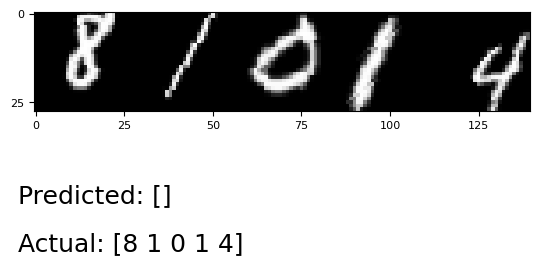

Finished training crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_01__BS128__BSV64 and took 30.25330877304077 seconds.
Training crnn-adam_step_lr_G128__L2__H4__W32__LR0_001__BS64__BSV64
100%|██████████| 11/11 [00:03<00:00,  3.48it/s]
EPOCH 1/8 - TRAINING. Loss: 2.6605703830718994 - Correct: 0/700 = 0.0000 - Average CER Score: 0.99
100%|██████████| 5/5 [00:00<00:00,  8.24it/s]
EPOCH 1/8 - VALIDATING. Loss: 2.7351558208465576 -  Correct: 0/299 = 0.0000 - Average CER Score: 1.0
100%|██████████| 11/11 [00:03<00:00,  3.32it/s]
EPOCH 2/8 - TRAINING. Loss: 2.727761745452881 - Correct: 0/700 = 0.0000 - Average CER Score: 0.995
100%|██████████| 5/5 [00:00<00:00,  9.57it/s]
EPOCH 2/8 - VALIDATING. Loss: 2.6743576526641846 -  Correct: 0/299 = 0.0000 - Average CER Score: 1.0
100%|██████████| 11/11 [00:03<00:00,  3.21it/s]
EPOCH 3/8 - TRAINING. Loss: 2.5915238857269287 - Correct: 0/700 = 0.0000 - Average CER Score: 0.997
100%|██████████| 5/5 [00:00<00:00,  9.13it/s]
EPOCH 3/8 - VALIDATING. Loss: 2.62

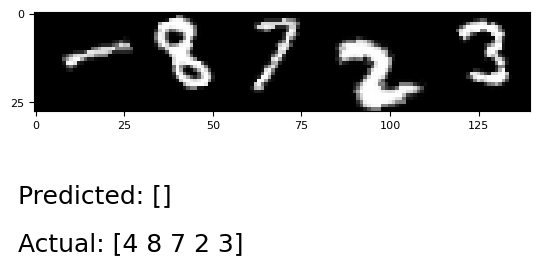

Finished training crnn-adam_step_lr_G128__L2__H4__W32__LR0_001__BS64__BSV64 and took 30.29495882987976 seconds.
Training crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_001__BS64__BSV64
100%|██████████| 11/11 [00:03<00:00,  3.52it/s]
EPOCH 1/8 - TRAINING. Loss: 2.095062494277954 - Correct: 0/700 = 0.0000 - Average CER Score: 0.97
100%|██████████| 5/5 [00:00<00:00,  9.96it/s]
EPOCH 1/8 - VALIDATING. Loss: 2.0610551834106445 -  Correct: 0/299 = 0.0000 - Average CER Score: 0.987
100%|██████████| 11/11 [00:03<00:00,  3.51it/s]
EPOCH 2/8 - TRAINING. Loss: 1.8524380922317505 - Correct: 0/700 = 0.0000 - Average CER Score: 0.954
100%|██████████| 5/5 [00:00<00:00, 10.01it/s]
EPOCH 2/8 - VALIDATING. Loss: 1.8307538032531738 -  Correct: 0/299 = 0.0000 - Average CER Score: 0.947
100%|██████████| 11/11 [00:03<00:00,  3.49it/s]
EPOCH 3/8 - TRAINING. Loss: 1.6877140998840332 - Correct: 0/700 = 0.0000 - Average CER Score: 0.919
100%|██████████| 5/5 [00:00<00:00,  8.60it/s]
EPOCH 3/8 - VALIDATING. Loss: 

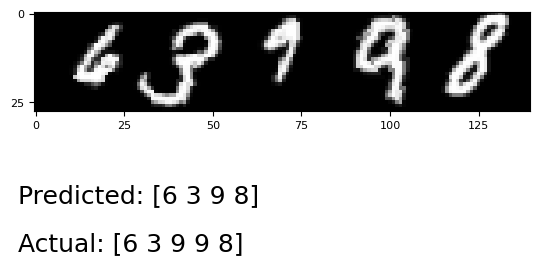

Finished training crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_001__BS64__BSV64 and took 30.618264198303223 seconds.


In [6]:
import time

metrics_global = {}
for model_name, trainer in trainers.items():
    print(f"Training {model_name}")
    start_time = time.time()
    metrics = trainer.train_validate_test()
    end_time = time.time()
    print(f"Finished training {model_name} and took {end_time - start_time} seconds.")
    # Save the trained model with abbreviation and parameter values
    main_model_name = model_name.split('-', 1)[0]
    base_path = f'models/{main_model_name}/{model_name}/'

    # Add metrics to model name
    metrics_global[f"{model_name}"] = metrics
    
    # Save model to disk
    create_directory_if_not_exists(base_path)
    save_path = base_path + "model.pth"
    torch.save(trainer.model.state_dict(), save_path)

In [7]:
from utils import get_dict_from_pkl, save_dict_to_pkl
# Save and load metrics to file
save_dict_to_pkl(metrics_global, "metrics_global")
grid_search_metrics = get_dict_from_pkl("metrics_global")

In [8]:
# Get top 5 models based on loss
top_models = {}

for model_name, model_scores_top_5 in grid_search_metrics.items():
    model_loss = model_scores_top_5["test_loss"][0]
    top_models[model_name] = model_loss

# Sort models by loss (ascending order)
sorted_models = dict(sorted(top_models.items(), key=lambda item: item[1]))

# Get top 5 models
top_5_models = dict(list(sorted_models.items())[:5])

# Create a new dictionary with numerical keys
numerical_top_models = {model: {"id": idx, "loss": loss} for idx, (model, loss) in enumerate(top_5_models.items())}

# Print the top 5 models with numerical keys
for item in numerical_top_models.items():
    print(item)


('crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_001__BS64__BSV64', {'id': 0, 'loss': 0.5937039256095886})
('crnn-adam_step_lr_G128__L2__H4__W32__LR0_001__BS64__BSV64', {'id': 1, 'loss': 2.2639777660369873})
('crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_01__BS64__BSV64', {'id': 2, 'loss': 2.363548755645752})
('crnn-adam_step_lr_G128__L2__H4__W32__LR0_01__BS64__BSV64', {'id': 3, 'loss': 2.5298080444335938})
('crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_01__BS128__BSV64', {'id': 4, 'loss': 2.6194815635681152})


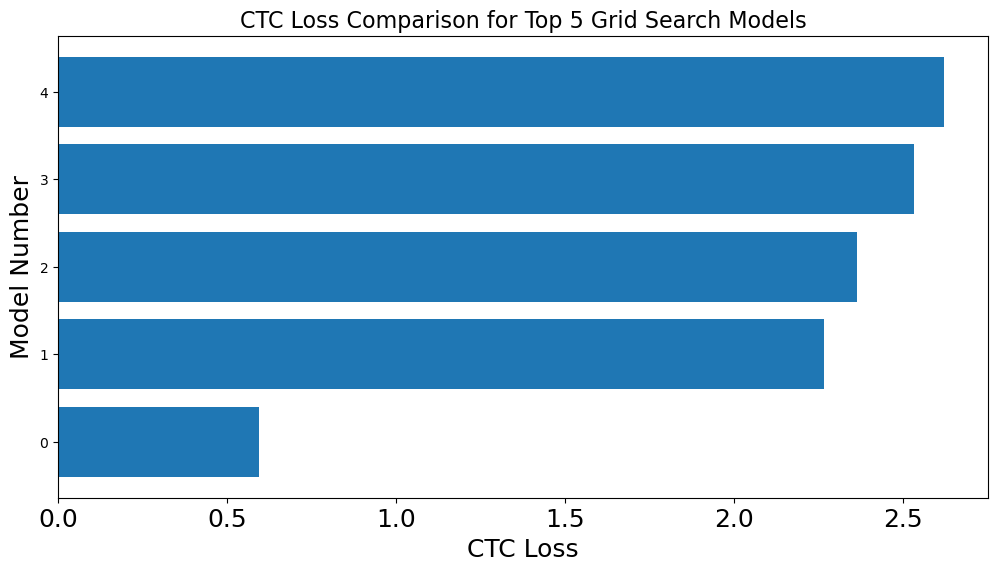

In [9]:
import numpy as np
from utils import split_and_insert_newline_list 
import matplotlib.pyplot as plt

model_names_top_5 = list(numerical_top_models.keys())
model_number_top_5 = [item["id"] for idx, item in numerical_top_models.items()]
model_scores_top_5 = [item["loss"] for idx, item in numerical_top_models.items()]

# Create a horizontal bar plot for all metrics
# Update fig size
plt.figure(figsize=(12, 6), dpi=100)

plt.barh(model_number_top_5, model_scores_top_5)  # Horizontal bar plot

plt.xlabel('CTC Loss')  # Adjust label
plt.ylabel('Model Number')  # Adjust label
plt.title('CTC Loss Comparison for Top 5 Grid Search Models', fontsize=16)  # Adjust title font size

# Customize font size for model names
plt.yticks(fontsize=10)

plt.show()


In [10]:
for model_name, trainer in trainers.items():
    main_model_name = model_name.split('-', 1)[0]
    # Get model paths
    base_path = f'models/{main_model_name}/{model_name}/'
    model_path = base_path + "model.pth"
    
    print(f"Saving Loss Plot for model: {model_name}")
    #model = model.to("mps")
    model.load_state_dict(torch.load(model_path))

    # Plot the trained model
    plot_loss(model_name=model_name, train_loss_per_epoch=trainer.metrics["train_loss"], val_loss_per_epoch=trainer.metrics["val_loss"], figure_evaluation_dir=base_path)

Saving Loss Plot for model: crnn-adam_step_lr_G128__L2__H4__W32__LR0_01__BS64__BSV64
Saving Loss Plot for model: crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_01__BS64__BSV64
Saving Loss Plot for model: crnn-adam_step_lr_G128__L2__H4__W32__LR0_01__BS128__BSV64
Saving Loss Plot for model: crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_01__BS128__BSV64
Saving Loss Plot for model: crnn-adam_step_lr_G128__L2__H4__W32__LR0_001__BS64__BSV64
Saving Loss Plot for model: crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_001__BS64__BSV64


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [11]:
#TODO Plot training and val for each model

model_ids = []
model_training_losses = []
model_val_losses = []

for model_name, trainer in trainers.items():
    if model_name in model_names_top_5:
        model_id = numerical_top_models[model_name]["id"]
        model_ids.append(model_id)
        model_training_losses.append(trainer.metrics["train_loss"])
        model_val_losses.append(trainer.metrics["val_loss"])

# Get model paths
main_model_name = model_name.split('-', 1)[0]
base_path = f'models/{main_model_name}/'

# Plot the trained model
plot_multiple_losses(
    model_names=model_ids, 
    train_losses_list=model_training_losses, 
    val_losses_list=model_val_losses, 
    figure_evaluation_dir=base_path
)

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

Testing model crnn-adam_step_lr_G128__L2__H4__W32__LR0_01__BS64__BSV64
100%|██████████| 1/1 [00:00<00:00, 109.26it/s]
TESTING. Loss: 2.363548755645752 -  Correct: 0/1 = 0.0000 - Average CER Score: 1.0


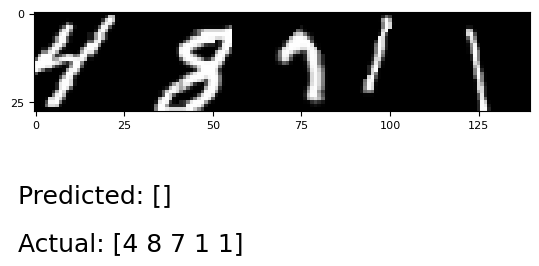

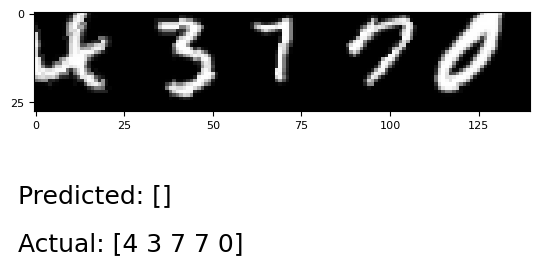

Testing model crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_01__BS64__BSV64
100%|██████████| 1/1 [00:00<00:00, 34.66it/s]
TESTING. Loss: 2.363548755645752 -  Correct: 0/1 = 0.0000 - Average CER Score: 0.995


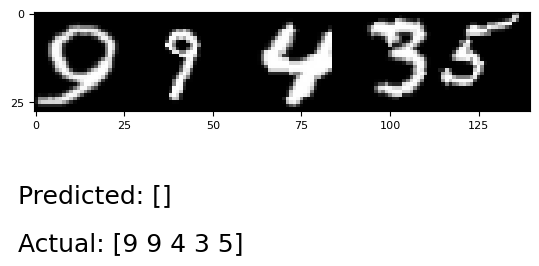

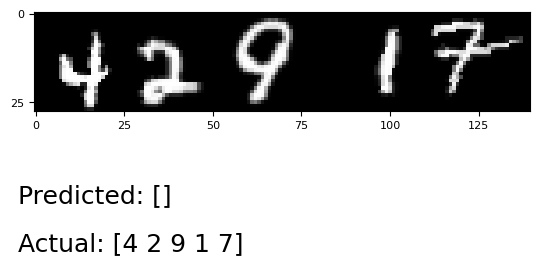

Testing model crnn-adam_step_lr_G128__L2__H4__W32__LR0_01__BS128__BSV64
100%|██████████| 1/1 [00:00<00:00, 73.92it/s]
TESTING. Loss: 2.6194815635681152 -  Correct: 0/1 = 0.0000 - Average CER Score: 0.987


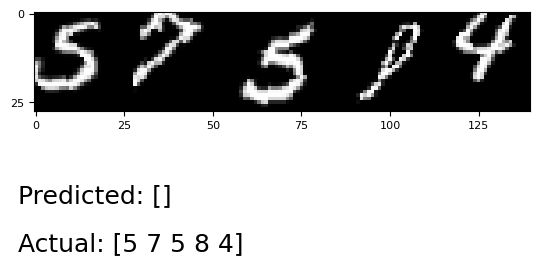

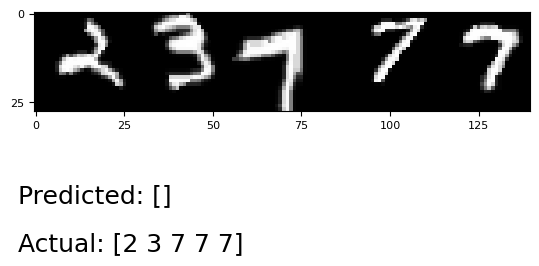

Testing model crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_01__BS128__BSV64
100%|██████████| 1/1 [00:00<00:00, 99.95it/s]
TESTING. Loss: 2.6194815635681152 -  Correct: 0/1 = 0.0000 - Average CER Score: 1.0


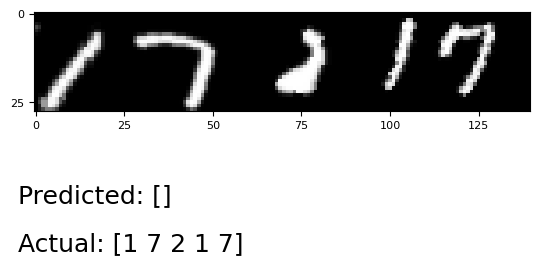

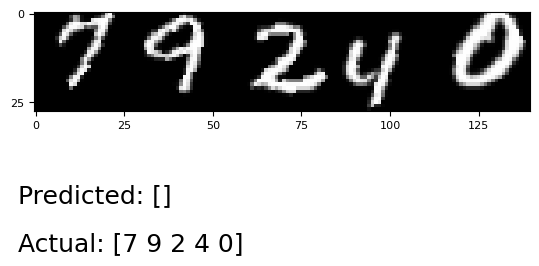

Testing model crnn-adam_step_lr_G128__L2__H4__W32__LR0_001__BS64__BSV64
100%|██████████| 1/1 [00:00<00:00, 135.78it/s]
TESTING. Loss: 0.5937039256095886 -  Correct: 0/1 = 0.0000 - Average CER Score: 0.998


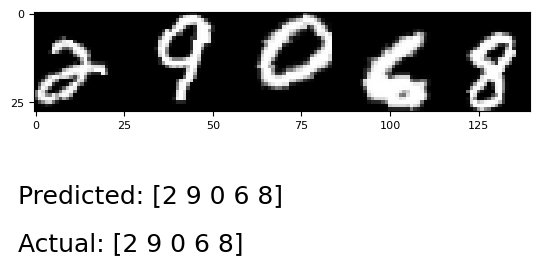

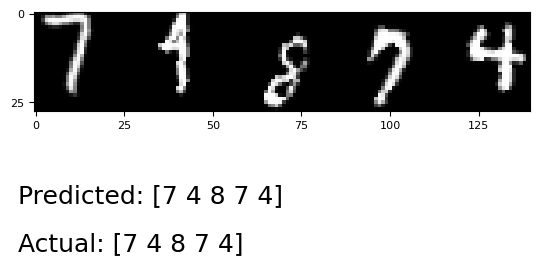

Testing model crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_001__BS64__BSV64
100%|██████████| 1/1 [00:00<00:00, 81.95it/s]
TESTING. Loss: 0.5937039256095886 -  Correct: 0/1 = 0.0000 - Average CER Score: 0.634


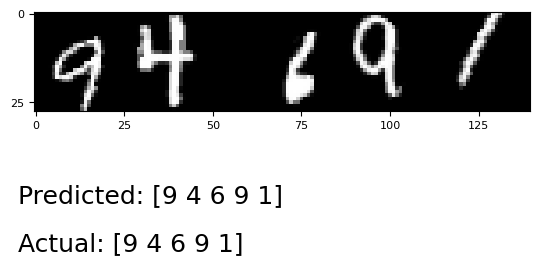

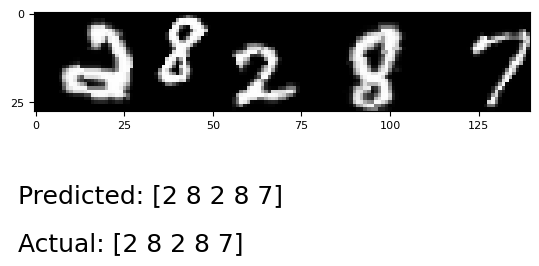

Testing model crnn-adam_step_lr_G128__L2__H4__W32__LR0_01__BS64__BSV64
100%|██████████| 1/1 [00:00<00:00, 55.39it/s]
TESTING. Loss: 2.363548755645752 -  Correct: 0/1 = 0.0000 - Average CER Score: 1.0


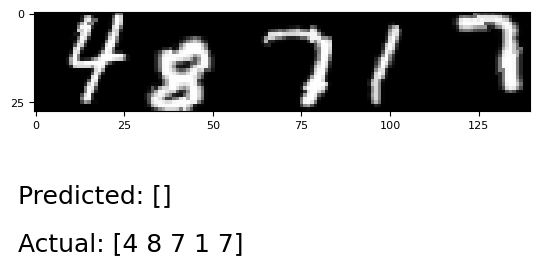

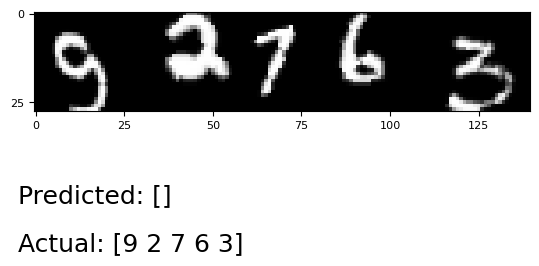

Testing model crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_01__BS64__BSV64
100%|██████████| 1/1 [00:00<00:00, 125.00it/s]
TESTING. Loss: 2.363548755645752 -  Correct: 0/1 = 0.0000 - Average CER Score: 0.995


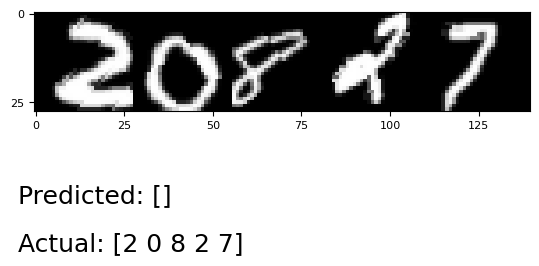

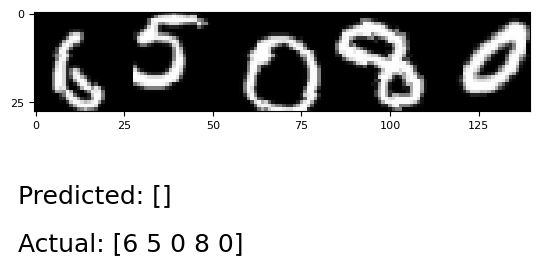

Testing model crnn-adam_step_lr_G128__L2__H4__W32__LR0_01__BS128__BSV64
100%|██████████| 1/1 [00:00<00:00, 67.25it/s]
TESTING. Loss: 2.6194815635681152 -  Correct: 0/1 = 0.0000 - Average CER Score: 0.987


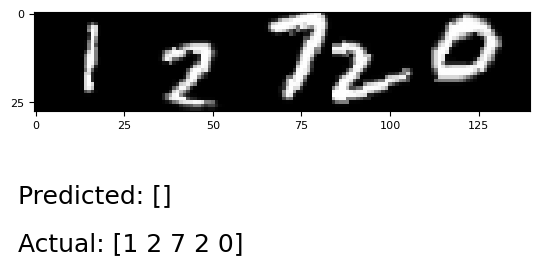

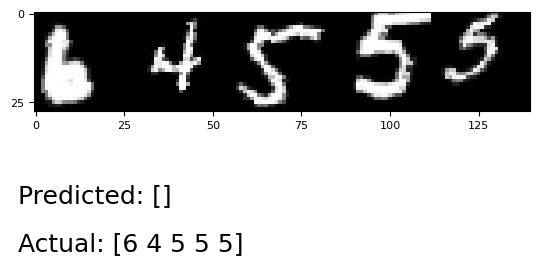

Testing model crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_01__BS128__BSV64
100%|██████████| 1/1 [00:00<00:00, 97.89it/s]
TESTING. Loss: 2.6194815635681152 -  Correct: 0/1 = 0.0000 - Average CER Score: 1.0


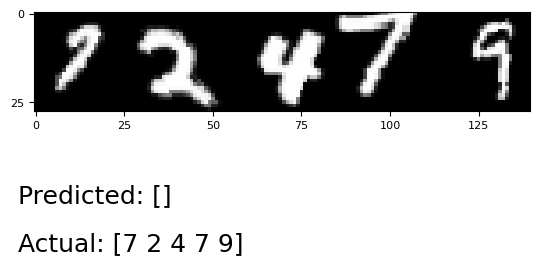

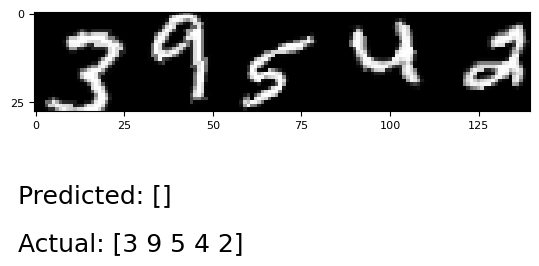

Testing model crnn-adam_step_lr_G128__L2__H4__W32__LR0_001__BS64__BSV64
100%|██████████| 1/1 [00:00<00:00, 95.09it/s]
TESTING. Loss: 0.5937039256095886 -  Correct: 0/1 = 0.0000 - Average CER Score: 0.998


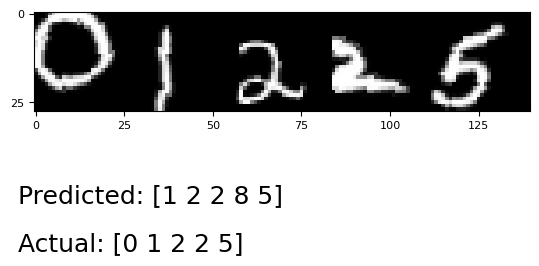

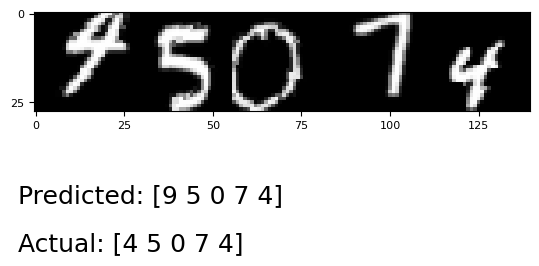

Testing model crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_001__BS64__BSV64
100%|██████████| 1/1 [00:00<00:00, 47.46it/s]
TESTING. Loss: 0.5937039256095886 -  Correct: 0/1 = 0.0000 - Average CER Score: 0.634


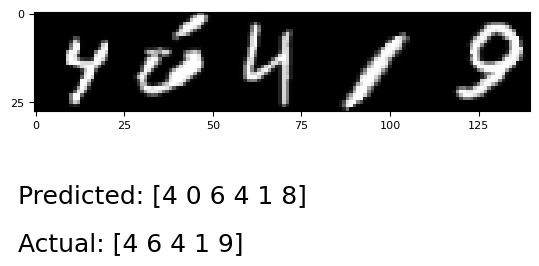

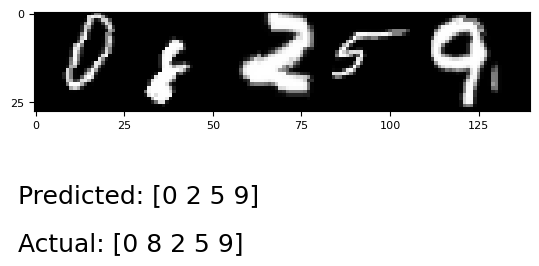

Testing model crnn-adam_step_lr_G128__L2__H4__W32__LR0_01__BS64__BSV64
100%|██████████| 1/1 [00:00<00:00, 87.47it/s]
TESTING. Loss: 2.363548755645752 -  Correct: 0/1 = 0.0000 - Average CER Score: 1.0


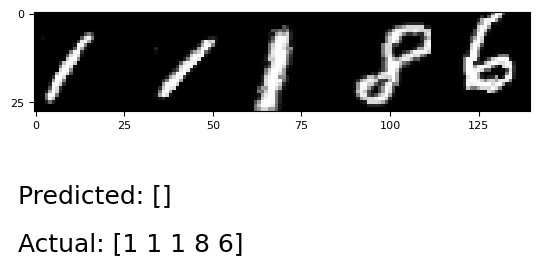

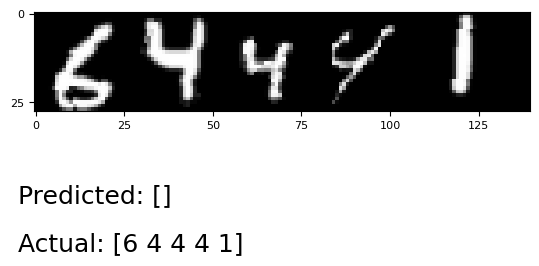

Testing model crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_01__BS64__BSV64
100%|██████████| 1/1 [00:00<00:00, 88.07it/s]
TESTING. Loss: 2.363548755645752 -  Correct: 0/1 = 0.0000 - Average CER Score: 0.995


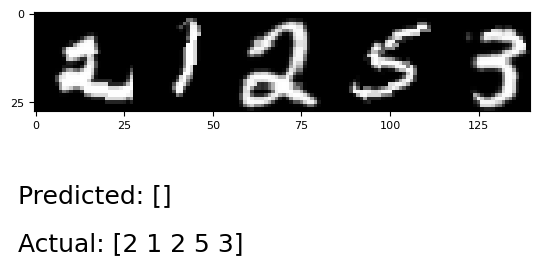

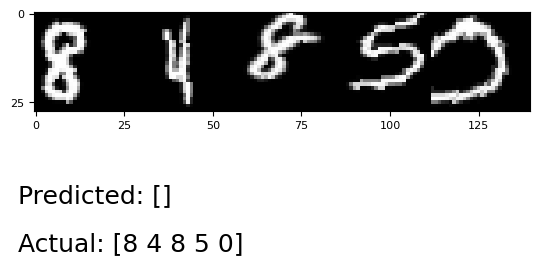

Testing model crnn-adam_step_lr_G128__L2__H4__W32__LR0_01__BS128__BSV64
100%|██████████| 1/1 [00:00<00:00, 83.67it/s]
TESTING. Loss: 2.6194815635681152 -  Correct: 0/1 = 0.0000 - Average CER Score: 0.987


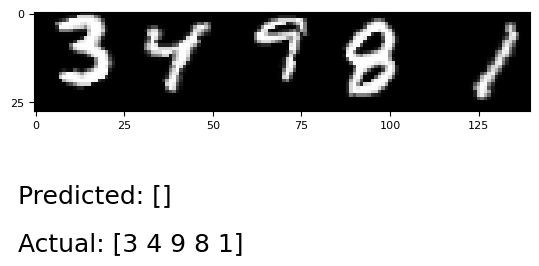

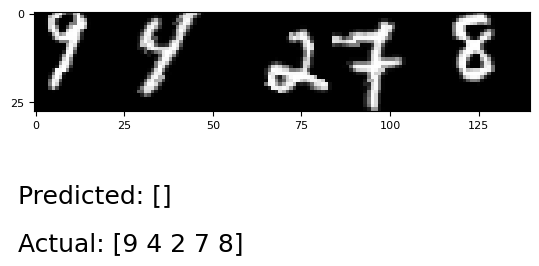

Testing model crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_01__BS128__BSV64
100%|██████████| 1/1 [00:00<00:00, 100.27it/s]
TESTING. Loss: 2.6194815635681152 -  Correct: 0/1 = 0.0000 - Average CER Score: 1.0


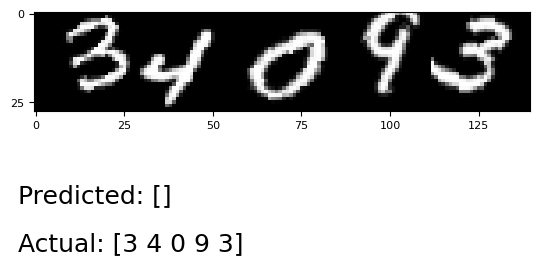

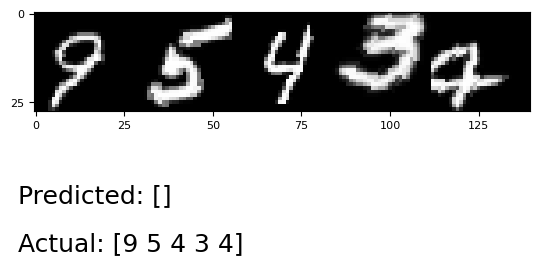

Testing model crnn-adam_step_lr_G128__L2__H4__W32__LR0_001__BS64__BSV64
100%|██████████| 1/1 [00:00<00:00, 101.13it/s]
TESTING. Loss: 0.5937039256095886 -  Correct: 0/1 = 0.0000 - Average CER Score: 0.998


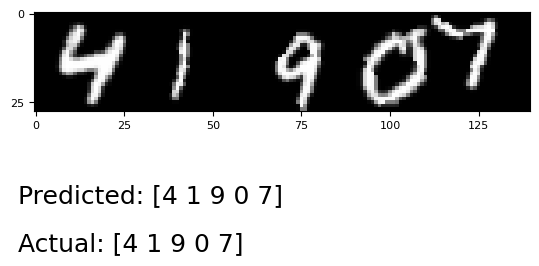

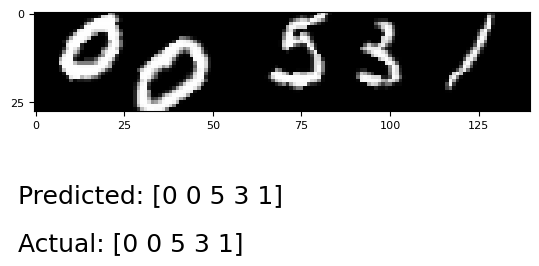

Testing model crnn-adam_no_scheduler_G128__L2__H4__W32__LR0_001__BS64__BSV64
100%|██████████| 1/1 [00:00<00:00, 75.15it/s]
TESTING. Loss: 0.5937039256095886 -  Correct: 0/1 = 0.0000 - Average CER Score: 0.634


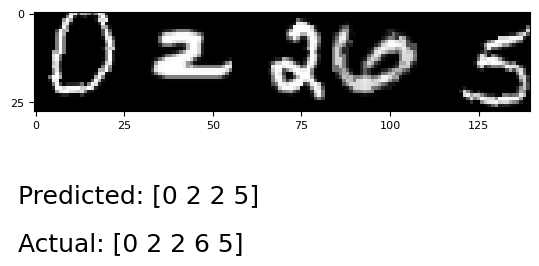

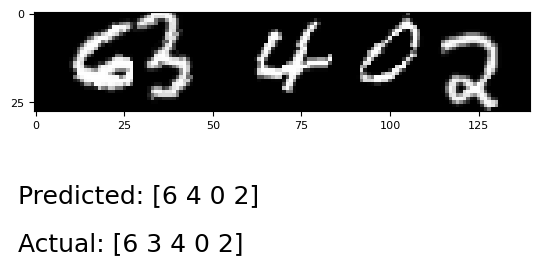

In [12]:
for param_combination in param_combinations: 
    
    gru_hidden_size = param_combination[0]
    gru_num_layers = param_combination[1]
    cnn_output_height = param_combination[2]
    cnn_output_width = param_combination[3]
    learning_rate = param_combination[4]
    batch_size = param_combination[5]
    batch_size_val = param_combination[6]

    for model_name, trainer in trainers.items():
        print(f"Testing model {model_name}")

        # Plot the trained model
        trainer.test(plot_n=2)